# Key Summary

### Frb 23:
- cleanse the code
- calculate the weight of each word in each topic

### Feb 17 & 19: impliment POS
- using POS seems to be an easier solution to rmove people's name and titles
- <font color='red'>topcis make more sense now</font>
- Next: remain country names
- idea: use (word, pos) to run topic modeling? 

### Feb 15: topic modeling on paragraphs 2019
- **Try paragraph-based topic modeling and <font color='red'>you can see the topcis are different now</font>**
- cleanse the code

### Feb 12: topic modeling on tf-idf files 2015-2019
- Tried tf-idf on all files, didn't work

### Feb 9: topic modeling on wordcount vector files 2015-2019
As discussed on Feb 3, the input of dynamic topic modeling are files, so I postponed parsing transcripts into paragraphs.

- I downloaded all transcripts from 2015-2019 
- First topic modeling result


### Feb 1: parsing files
- Parse fancy files
- the basic unit: each paragraph spoken by one person (i.e. the content divided by dotted line)
- clean those words that are repeated and obviously useless
- Words appeared in the front page and CORPORATE PARTICIPANTS session are repeated and contain no information


### Jan 27 
- I tried different package to read pdf, and pdftotext works best for the transcripts files
- There are two format types. One is fancier. 
- My next step is to parse the fancier files.


### Reference
- Topic Modeling in Python: Latent Dirichlet Allocation (LDA) https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
- NLTK POS tag list: https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/

# Working: topic modeling on paragraphs 2019

In [287]:
import pandas as pd
import os
from itertools import chain
from transcript_functions import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

year = 2019
path = os.getcwd() + '\Transcripts' + "\\" + str(year)

In [288]:
# get file names
files = pd.DataFrame(os.listdir(path), columns=["filename"])

# check if it's a fancy(FACTSET) file
files["type"] = files["filename"].map(lambda x: is_FactSet(path + "\\" + x))

# select FactSet files
Factset = files[ files["type"] == "FactSet" ].copy()

# parse all FactSet files and store into a dataframe
#######################################################
### this only applys to FactSet files, need to revise
######################################################
df = filenames_to_para(path, Factset["filename"])

In [289]:
# Factset["date"] = Factset["filename"].map(lambda x: x.split("_")[0])
# Factset["event"] = Factset["filename"].map(lambda x: x.split("_")[1])
# Factset["event"] = Factset["event"].map(lambda x: x.split(".")[0])
# Factset.sort_values(["date"]).to_csv("Factset.csv")

In [290]:
df.head()

,paragraph,date
0,Daniel Binder Vice President-Investor Relation...,2019-02-19
1,"C. Douglas McMillon President, Chief Executive...",2019-02-19
2,Brett M. Biggs Chief Financial Officer & Execu...,2019-02-19
3,QUESTION AND ANSWER SECTION Operator: Thank yo...,2019-02-19
4,"Simeon Ari Gutman Analyst, Morgan Stanley & Co...",2019-02-19


In [291]:
df["paragraph"][5]

"Brett M. Biggs Chief Financial Officer & Executive Vice President,                                                                                                                                                                              A Yeah, thanks, Simeon. We've talked a lot over the last few months about – last three quarters about expense leverage. It comes from a number of different places. We're seeing great expense leverage in the U.S., certainly good comp sales helps a lot with that. But as the technology and the training that we've done in the past – technology we've put in place and the training we've done over the past several years is really paying dividends in the stores with our associates and how we serve our customers. So, as you saw even in October, some of the technology that's coming, some things we keep doing with our stores, we expect the productivity in the U.S. stores will continue to be a big part of what we do. When you look at really around the world, we

In [292]:
nltk.download('averaged_perceptron_tagger')
text = word_tokenize(df["paragraph"][5])
nltk.pos_tag(text)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('Brett', 'NNP'),
 ('M.', 'NNP'),
 ('Biggs', 'NNP'),
 ('Chief', 'NNP'),
 ('Financial', 'NNP'),
 ('Officer', 'NNP'),
 ('&', 'CC'),
 ('Executive', 'NNP'),
 ('Vice', 'NNP'),
 ('President', 'NNP'),
 (',', ','),
 ('A', 'NNP'),
 ('Yeah', 'NNP'),
 (',', ','),
 ('thanks', 'NNS'),
 (',', ','),
 ('Simeon', 'NNP'),
 ('.', '.'),
 ('We', 'PRP'),
 ("'ve", 'VBP'),
 ('talked', 'VBN'),
 ('a', 'DT'),
 ('lot', 'NN'),
 ('over', 'IN'),
 ('the', 'DT'),
 ('last', 'JJ'),
 ('few', 'JJ'),
 ('months', 'NNS'),
 ('about', 'IN'),
 ('–', 'NN'),
 ('last', 'JJ'),
 ('three', 'CD'),
 ('quarters', 'NNS'),
 ('about', 'IN'),
 ('expense', 'JJ'),
 ('leverage', 'NN'),
 ('.', '.'),
 ('It', 'PRP'),
 ('comes', 'VBZ'),
 ('from', 'IN'),
 ('a', 'DT'),
 ('number', 'NN'),
 ('of', 'IN'),
 ('different', 'JJ'),
 ('places', 'NNS'),
 ('.', '.'),
 ('We', 'PRP'),
 ("'re", 'VBP'),
 ('seeing', 'VBG'),
 ('great', 'JJ'),
 ('expense', 'JJ'),
 ('leverage', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('U.S.', 'NNP'),
 (',', ','),
 ('certainly', 'RB'),

## Preprocessing

In [293]:
df["tokens"] = df["paragraph"].map(nltk.word_tokenize)

# tag Part of Speech
df["tokens_pos"] = df["tokens"].map(nltk.pos_tag)

## to check distribution of POS tags
# df_all_tokens = get_all_wordsPos(df["tokens_pos"])

# filter words with pos not in pos_remaining
pos_remaining = ["NN", "NNS", 
                 "VB", "VBD", "VBN", "VBP", "VBZ"
                ] # take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_remaining])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_clean"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

# remove rows that have no content after lemmatization
df = df[df["tokens_clean"].map(lambda x: len(x)>=1)]

# remove punctuation
punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in punctuation])

# remove stop words
stop_words = set(stopwords.words('english'))
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove some specific cases
others = ["'s", "'re", "'ve", "n't", "'ll", "–", "'m"]
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in others])

# lower case
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word.lower() for word in x])

# # remove short words
# df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if len(word)>3])

# # remove long words
# df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if len(word)<16])

In [294]:
# # look at unique words to get a sense what needs to be delete
# unique_words = get_unique_words(df["tokens_clean"])

## LDA

In [295]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# the input of CountVectorizer is corpe 
df["corpus"] = df["tokens_clean"].map(lambda x: ', '.join(x))
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df["corpus"])

In [296]:
number_topics = 15
number_words = 10

# fix random_state at 33
lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)
       
print_topics(lda, count_vectorizer, number_words)


Topic #0:
think customer get year thing talk look quarter statement ecommerce

Topic #1:
store grocery get pickup basket online people customer think lot

Topic #2:
think price brand lot want get customer go year make

Topic #3:
ph kind investment get seem and take color need store

Topic #4:
business market payment year customer think technology see platform ecommerce

Topic #5:
question line investment operator thank audience proceed come know start

Topic #6:
think thing year time change store go get kind customer

Topic #7:
think price delivery get customer cost category want business supplier

Topic #8:
year sale think quarter business growth continue expect inventory change

Topic #9:
get say think year feel lot culture point way come

Topic #10:
think store customer get business want thing time lot way

Topic #11:
think get thing make store lot time brand talk guy

Topic #12:
think year look growth get store number time way thing

Topic #13:
information offer report herein trad

## Processing after

In [297]:
removing_words = [
    "get", "think", "thing", "know", "kind", "way", "look", "year",
     "question", "guy", "thank", "quarter", "lot", "want", "herein",
    "talk", "guess", "see", "say", "make", "go", "store", "customer",
    "business", "time", "ph", "take", "bit", "work", "morning",
    "company", "mean"
]

df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in removing_words])

In [298]:
df["corpus"] = df["tokens_clean"].map(lambda x: ', '.join(x))
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df["corpus"])

number_topics = 10

# fix random_state at 33
lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)
       
number_words = 12
print_topics(lda, count_vectorizer, number_words)


Topic #0:
grocery need pickup basket statement today point online food add mix investment

Topic #1:
technology come brand give product label team continue something leverage expense put

Topic #2:
brand category need people capital home apparel part help number commerce focus

Topic #3:
delivery price people strategy investment cost pickup continue service grocery house happen

Topic #4:
growth market sale item opportunity inventory expect continue ecommerce number change point

Topic #5:
grocery team ecosystem payment opportunity service investment idea merchandise create data help

Topic #6:
price change brand people part assortment investment come gap continue experience grocery

Topic #7:
information report offer trademark data use guarantee investment opinion accuracy solicitation security

Topic #8:
line feel need people change operator healthcare proceed give come team quality

Topic #9:
market start investment people today ecommerce scale feel money wage couple tension


In [299]:
words = count_vectorizer.get_feature_names()

for topic in range(0,number_topics):
    topic_vec = lda.components_[topic]
    topic_idx = topic_vec.argsort()[:-10 - 1:-1]
    print("topic:", topic, " ====================")
    for i in topic_idx:
        print('{:<10} {:>10.2%}'.format(words[i], topic_vec[i]/topic_vec.sum()))

topic: 0  ====================
grocery         4.51%
need            1.92%
pickup          1.83%
basket          1.40%
statement       1.27%
today           1.26%
point           1.05%
online          0.99%
food            0.97%
add             0.86%
topic: 1  ====================
technology      1.83%
come            1.55%
brand           1.48%
give            1.47%
product         1.44%
label           1.23%
team            1.10%
continue        1.01%
something       0.97%
leverage        0.94%
topic: 2  ====================
brand           3.49%
category        1.53%
need            1.31%
people          1.12%
capital         1.11%
home            1.11%
apparel         1.03%
part            0.94%
help            0.93%
number          0.92%
topic: 3  ====================
delivery        3.14%
price           1.52%
people          1.25%
strategy        1.23%
investment      1.18%
cost            1.10%
pickup          1.07%
continue        0.98%
service         0.82%
grocery         0.

## Check topic for each paragraph

In [300]:
topic_match = lda.transform(count_data)
df["topic"] = pd.Series([ x.argsort()[-1] + 1 for x in topic_match])

#### ????

In [353]:
sum(df["topic"].isna())
sum(pd.DataFrame(topic_match).isna())
sum(pd.Series([ x.argsort()[-1] + 1 for x in topic_match]).isna())

0

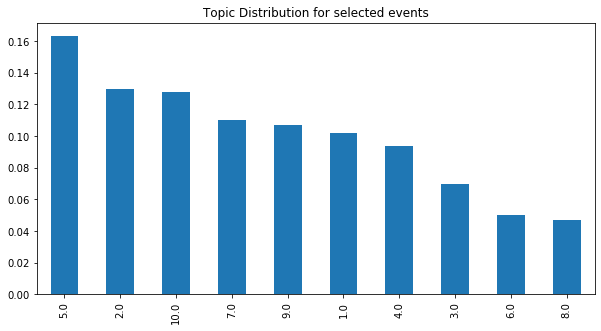

In [301]:
import matplotlib.pyplot as plt
%matplotlib inline  
topic_counts = df["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="percentage",
                                       title="Topic Distribution for selected events",
                                       kind="bar", figsize=(10,5))

Text(0.5, 1.0, 'Topic distribution across events')

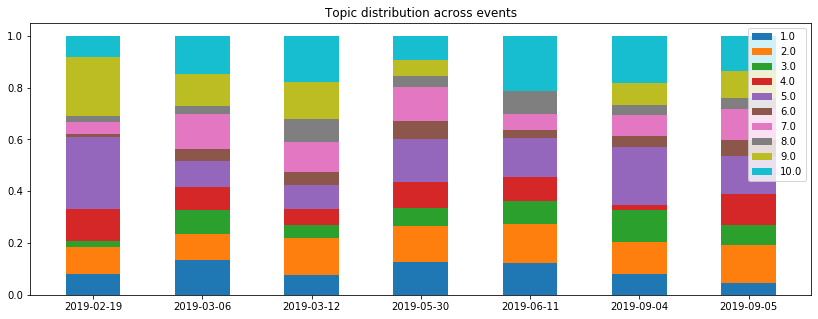

In [338]:
event_tp = df.groupby(by=["date","topic"])["topic"].count().unstack().fillna(0)
tmp = event_tp.T.apply(sum)
event_tp = event_tp.apply(lambda x: x/tmp)
event_tp.index = [str(x)[:10] for x in event_tp.index]

fig, ax = plt.subplots(figsize=(14, 5))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
          'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
bottom = np.array([0]*event_tp.shape[0])
x = event_tp.index.values

for i in event_tp.columns:
#     print(event_tp[i].values)
    plt.bar(x, event_tp[i].values, width=0.5, color=colors[int(i-1)], bottom=bottom)
    bottom = bottom + event_tp[i]

plt.legend(event_tp.columns)
plt.title("Topic distribution across events")

In [348]:
df[df["date"]=="2019-11-15"]

,paragraph,date,tokens,tokens_pos,tokens_clean,corpus,topic
786,MANAGEMENT DISCUSSION SECTION Ben Bienvenu Ana...,2019-11-15,"[MANAGEMENT, DISCUSSION, SECTION, Ben, Bienven...","[(Thanks, NNS), (everybody, NN), (think, VBP),...","[thanks, everybody, kick, cover, grocery, conv...","thanks, everybody, kick, cover, grocery, conve...",NaN
787,Brett M. Biggs Chief Financial Officer & Execu...,2019-11-15,"[Brett, M., Biggs, Chief, Financial, Officer, ...","[(pleasure, NN)]",[pleasure],pleasure,NaN
788,"Ben Bienvenu Analyst, Stephens, Brett, I thin...",2019-11-15,"[Ben, Bienvenu, Analyst, ,, Stephens, ,, Brett...","[(think, VBP), (make, VB), (statement, NN), (k...","[statement, kick]","statement, kick",NaN
789,Brett M. Biggs Chief Financial Officer & Execu...,2019-11-15,"[Brett, M., Biggs, Chief, Financial, Officer, ...","[(think, VBP), (webcast, NN), (have, VBP), (sl...","[webcast, slide, consider, investment, conside...","webcast, slide, consider, investment, consider...",NaN
792,QUESTION AND ANSWER SECTION Ben Bienvenu Analy...,2019-11-15,"[QUESTION, AND, ANSWER, SECTION, Ben, Bienvenu...","[(QUESTION, NN), (years, NNS), (kicked, VBD), ...","[kick, turnaround, plan, reinvigorate, growth,...","kick, turnaround, plan, reinvigorate, growth, ...",NaN
793,Brett M. Biggs Chief Financial Officer & Execu...,2019-11-15,"[Brett, M., Biggs, Chief, Financial, Officer, ...","[('re, VBP), (day, NN), (is, VBZ), (–, VB), (g...","[day, 1970s, credit, derivative, retail, price...","day, 1970s, credit, derivative, retail, price,...",NaN
794,"Ben Bienvenu Analyst, Stephens, ...",2019-11-15,"[Ben, Bienvenu, Analyst, ,, Stephens, ,, Q, Ma...","[(follow-up, NN), (had, VBD), (announcement, N...","[follow-up, announcement, building, track, rec...","follow-up, announcement, building, track, reco...",NaN
795,Brett M. Biggs Chief Financial Officer & Execu...,2019-11-15,"[Brett, M., Biggs, Chief, Financial, Officer, ...","[(is, VBZ), (legend, NN), ('ve, VBP), (been, V...","[legend, privilege, partner, role, miss, numbe...","legend, privilege, partner, role, miss, number...",NaN
796,"Ben Bienvenu Analyst, Stephens, ...",2019-11-15,"[Ben, Bienvenu, Analyst, ,, Stephens, ,, Q, On...","[(play, NN), (is, VBZ), (pickup, NN), ('s, VBZ...","[play, pickup, initiative, wife, use]","play, pickup, initiative, wife, use",NaN
797,Brett M. Biggs Chief Financial Officer & Execu...,2019-11-15,"[Brett, M., Biggs, Chief, Financial, Officer, ...","[(do, VBP)]",[],,NaN


## Below is work before POS

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(count_data) # the input of TfidfTransformer is a matrix of term/token counts
tf_idf_vector = tfidf_transformer.transform(count_data)

number_topics = 10
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(tf_idf_vector)
print_topics(lda, count_vectorizer, number_words)


Topic #0:
barclays karen short capital thank operator proceed line please next

Topic #1:
pile money development house audience 24 replicate degree either india

Topic #2:
sure pleasure true reasonable super specifically fair card india confusing

Topic #3:
michael lasser securities okay balance thanks dastugue quickly idea mean

Topic #4:
stephens bienvenu richard international mayfield paul trussell deutsche thank bank

Topic #5:
officer walmart gregory foran solid carefully flag remember lost anything

Topic #6:
merchandising back great steve bratspies private part category first opportunity

Topic #7:
bank lynch ohmes merrill america robert sorry guy india scott

Topic #8:
information advertising herein provided including 00 bienvenu stephens correct report

Topic #9:
director douglas mcmillon learning decision holiday might current skus assuming


In [8]:
number_topics = 10
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)      
print_topics(lda, count_vectorizer, number_words)


Topic #0:
information capital short barclays karen including provided herein report without

Topic #1:
pickup delivery basket merchandise seeing term shop serve assortment service

Topic #2:
bank securities paul trussell deutsche guy pretty term sure skus

Topic #3:
technology thank feel pretty sure statement place thanks trying 00

Topic #4:
private label long guy five money even inside probably channel

Topic #5:
private category label world model delivery number space versus important

Topic #6:
stephens bienvenu 00 quarter mean next line first please okay

Topic #7:
sale comp quarter margin product number leverage take billion expense

Topic #8:
commerce 00 feel place always world data program profitability done

Topic #9:
item delivery help million sure 00 feel doug center first


### Previous work

In [4]:
import pdftotext
import os
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline  

def get_text(filepath):
    pdfFileObj = open(filepath,'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    text = "\n\n".join(pdf)
    return(text)

In [2]:
%%time

path = os.getcwd() + '\data\Transcripts'
years = os.listdir(path)

# get all filenames and the text in the files
files = pd.DataFrame()
for year in years:
    filenames = os.listdir(path + "\\" + year)
    filepaths = [path + "\\" + year + "\\" + filename for filename in filenames]
    texts = [get_text(path) for path in filepaths]
    tmp = pd.DataFrame([filenames, texts]).T
    files = pd.concat([files, tmp], ignore_index=True)

files.columns = ["filename", "text"]

Wall time: 4.4 s


In [3]:
%%time
files["tokens"] = files["text"].map(nltk.word_tokenize)
files["tokens_count"] = files["tokens"].map(len)

Wall time: 9.01 s


#### Decide what words to be deleted

In [4]:
from itertools import chain
all_tokens = list(chain.from_iterable(files["tokens"]))
all_tokens = pd.Series(all_tokens)
tokens_count = all_tokens.value_counts()
len(tokens_count)

11937

In [5]:
%%time
unique_tokens = pd.DataFrame()
unique_tokens["token"] = tokens_count.index
unique_tokens["counts"] = tokens_count.values

punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
unique_tokens["punctuation"] = unique_tokens["token"].map(lambda x: x in punctuation)

stop_words = set(stopwords.words('english'))
unique_tokens["stop_words"] = unique_tokens["token"].map(lambda x: x.lower() in stop_words)

unique_tokens["only_twice"] = unique_tokens["counts"].map(lambda x: x <= 2)

unique_tokens["len"] = unique_tokens["token"].map(len)
unique_tokens["too_short"] = unique_tokens["len"] <= 2 # this might eliminate US and UK
unique_tokens["too_long"] = unique_tokens["len"] >= 16 

unique_tokens["apostrophe_comma"] = unique_tokens["token"].map(lambda x: '\'' in x or ',' in x)

removing = (unique_tokens["punctuation"] == True) | (unique_tokens["stop_words"] == True) \
| (unique_tokens["only_twice"] == True) | (unique_tokens["too_short"] == True) \
| (unique_tokens["too_long"] == True) | (unique_tokens["apostrophe_comma"] == True)

remain_token = unique_tokens[~removing]

# remain_token[remain_token["token"].map(lambda x: x[0].isupper())]

removing_words = unique_tokens[removing]["token"]

Wall time: 70.4 ms


In [20]:
len(remain_token)

5586

#### Visualize remaining words

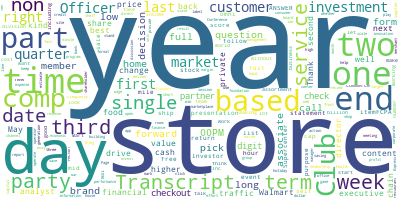

In [7]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(remain_token['token'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### Preparing data for LDA

In [35]:
%%time
## need to optimize here
files["cleansed_tokens"] = files["tokens"].map(lambda x: [word for word in x if word in remain_token["token"].values])

Wall time: 2min 50s


In [41]:
files["cleansed_tokens"][0]

['WAL-MART',
 'STORES',
 'INC.',
 'NYSE',
 'WMT',
 'Fourth',
 'Quarter',
 'Fiscal',
 'Year',
 '2015',
 'Earnings',
 'Call',
 'February',
 '2015',
 'Management',
 'call',
 'recorded',
 'Carol',
 'Schumacher',
 'Wal-Mart',
 'Stores',
 'Inc',
 'Global',
 'Investor',
 'Relations',
 'Hello',
 'Carol',
 'Schumacher',
 'vice',
 'president',
 'global',
 'investor',
 'relations',
 'Wal-Mart',
 'Stores',
 'Inc',
 'Thanks',
 'joining',
 'today',
 'date',
 'call',
 'February',
 '2015',
 'call',
 'property',
 'Wal-Mart',
 'Stores',
 'Inc.',
 'intended',
 'use',
 'Walmart',
 'shareholders',
 'investment',
 'community',
 'reproduced',
 'way',
 'listening',
 'phone',
 'may',
 'navigate',
 'call',
 'follows',
 'Press',
 'key',
 'rewind',
 'playback',
 'seconds',
 'Press',
 'key',
 'pause',
 'resume',
 'playback',
 'Press',
 'key',
 'fast-forward',
 'playback',
 'seconds',
 'call',
 'contain',
 'statements',
 'Walmart',
 'believes',
 'forward-',
 'looking',
 'statements',
 'within',
 'meaning',
 'Privat

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation as LDA

files["corpe"] = files["cleansed_tokens"].map(lambda x: ', '.join(x))
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(files["corpe"])

number_topics = 5
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_topics(lda, count_vectorizer, number_words)


Topic #0:
walmart year sales quarter percent comp growth customers business stores

Topic #1:
reuters thomson stores inc wal mart going year customers walmart

Topic #2:
reuters thomson stores inc walmart think going wal mart really

Topic #3:
walmart inc think chief officer executive president vice financial factset

Topic #4:
year really think walmart business current going one company customers


## 12th Feb
- use tfidf instead of count vector

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(count_data)
tf_idf_vector = tfidf_transformer.transform(count_data)

In [38]:
tf_idf_vector.shape

(48, 4758)

In [39]:
number_topics = 5
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(tf_idf_vector)

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_topics(lda, count_vectorizer, number_words)


Topic #0:
30 provisional self eight allowing marks somewhat finding commentary adjustments

Topic #1:
30 provisional self eight allowing marks somewhat finding commentary adjustments

Topic #2:
30 provisional self eight allowing marks somewhat finding commentary adjustments

Topic #3:
percent sales walmart quarter year comp growth increased results fiscal

Topic #4:
reuters walmart thomson think inc stores business going really year
